In [68]:
using JuMP;
using HiGHS;
using Plots;
using Distributions;
using Random;
using Statistics;
Random.seed!(1234);

Every morning, the newsboy goes to the editor of the newspaper and buys a quantity of $x$ of newspapers at a cost of $c$ per unit. This $x$ amount is limited upwards by a $u$ value, as the newsboy has finite purchasing power. The decision is made under uncertainty since the demand  $d$  newspapers of the day is unknown. The number of $y$ newspapers is sold at a price of $q$ per unit. The newsboy also has an agreement with the newspaper editor: the number of unsold newspapers $w$ can be returned to the editor, who pays a $r$ price for him.

Consider the two-stage formulation:

$$\min_{0 \leq x \leq u} cx + \mathbb{E}_d[Q(x,d)]$$

where, 

$$Q(x,d) = \min_{y, z} \left\{ -qy -rz | y \leq d; y + z \leq x; y, z \geq 0 \right\}$$ 

Let $c=10$, $r=5$, $q=25$ e $u=150$. Also, assume that the demand follows a (continuous) uniform probability distribution over the range $[50,150]$.

In [69]:
struct NewsboyData
    u::Float64
    c::Float64
    q::Float64
    r::Float64
    D::Uniform{Float64}
end

function get_newsboy_data(data::NewsboyData)
    u = data.u
    c = data.c
    q = data.q
    r = data.r
    D = data.D
    return u, c, q, r, D
end

function newsboy_optimal(data::NewsboyData, N::Int = 0)
    
    u, c, q, r, D = get_newsboy_data(data)
    p = 1/N
    d = rand(D, N)
    model = Model(HiGHS.Optimizer)
    MOI.set(model, JuMP.MOI.Silent(), true)
    @variable(model, 0<=x<=u)
    @variable(model, 0<=y[n=1:N]<=d[n])
    @variable(model, 0<=z[1:N])

    @constraint(model,[n = 1:N], y[n] + z[n] <= x)

    @objective(model, Min,c*x - sum(q*y[n]*p+r*z[n]*p for n = 1:N))

    optimize!(model)
    return objective_value(model), value(model[:x])
end

function newsboy_optimal_given_x(data::NewsboyData, x::Float64, N::Int = 0)
    
    u, c, q, r, D = get_newsboy_data(data)
    p = 1/N
    d = rand(D, N)
    model = Model(HiGHS.Optimizer)
    MOI.set(model, JuMP.MOI.Silent(), true)
    @variable(model, 0<=y[n=1:N]<=d[n])
    @variable(model, 0<=z[1:N])

    @constraint(model,[n = 1:N], y[n] + z[n] <= x)

    @objective(model, Min,c*x - sum(q*y[n]*p+r*z[n]*p for n = 1:N))

    optimize!(model)
    return objective_value(model)
end

data = NewsboyData(150,10,25,5,Uniform(50,150));

## 1) Using Sample Average Approximations, compute and plot the confidence interval for the lower bound for a fixed number of replications $M=10$ and a varying number of in-sample scenarios $N \in \{50,100, \ldots,1000\}$


In [70]:
M = 10
N_list = collect(50:50:1000)
Ns = length(N_list)

objs = zeros(M, Ns)
xs = zeros(M, Ns)

for i in 1:M, j in 1:Ns
    obj, x = newsboy_optimal(data, N_list[j])
    objs[i, j] = obj
    xs[i, j] = x
end

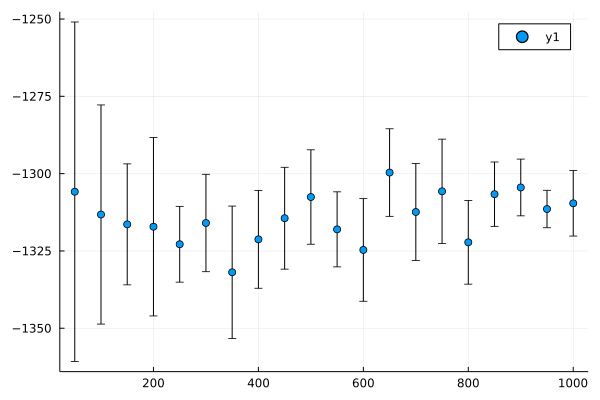

In [71]:
μ = reshape(mean(objs, dims = 1), Ns);
σ = reshape(std(objs, dims = 1), Ns);
scatter(N_list, μ, yerror = 1.96*σ/sqrt(M))

## 2) Assuming $N=1000$ scenarios for each problem and $M=10$ replications (solution candidates), compute the confidence interval for the upper bound for the number of out-of-sample scenarios $K = 1000$. Choose a candidate solution and justify your choice.


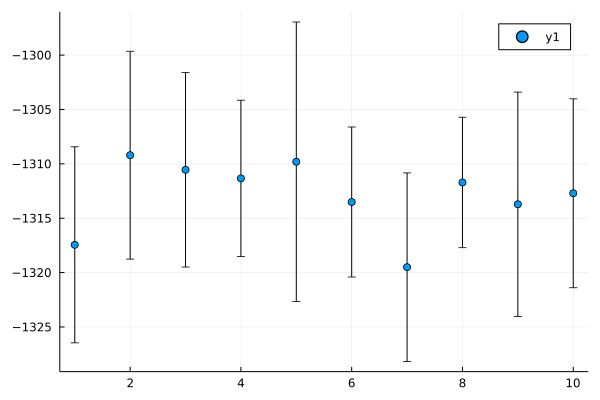

In [85]:
M = 10
N = 1000

obj_ub = zeros(M, M)

for i in 1:M
    x = xs[i, end]
    for j in 1:M
        obj = newsboy_optimal_given_x(data, x, N)
        obj_ub[j,i] = obj
    end
end
μ = reshape(mean(obj_ub, dims = 1), M)
σ = reshape(std(obj_ub, dims = 1), M);
scatter(1:10, μ, yerror = 1.96*σ/sqrt(M))

In [89]:
idx = argmin(μ);
x_choose = xs[idx,end];
println("In this case x = $(x_choose).")
println("Because this one produce the smaller average objective value obj = $(μ[idx]).")

In this case x = 124.00673087874617.
Because this one produce the smaller average objective value obj = -1319.500988366938.


## 3) Now, for the chosen solution, compute and plot the confidence interval for the UB for differing $K \in \{100, 200, ..., 1000\}$.


In [90]:
K_list = collect(100:100:1000)
Ks = length(K_list)

objs_k = zeros(M, Ks)

for  i in 1:M, j in 1:Ks
    obj = newsboy_optimal_given_x(data, x_choose, K_list[j])
    objs_k[i,j] = obj
end

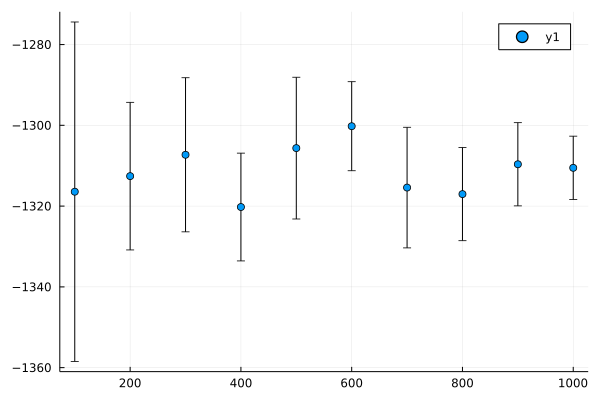

In [91]:
μ = reshape(mean(objs_k, dims = 1), Ks);
σ = reshape(std(objs_k, dims = 1), Ks);
scatter(K_list, μ, yerror = 1.96*σ/sqrt(M))

## 4) Assuming $N=1000$ scenarios for each problem and $M=10$ replications (solution candidates), compute a probabilistic  gap. Choose a candidate solution, justify your choice and compare with the previously chosen candidate.

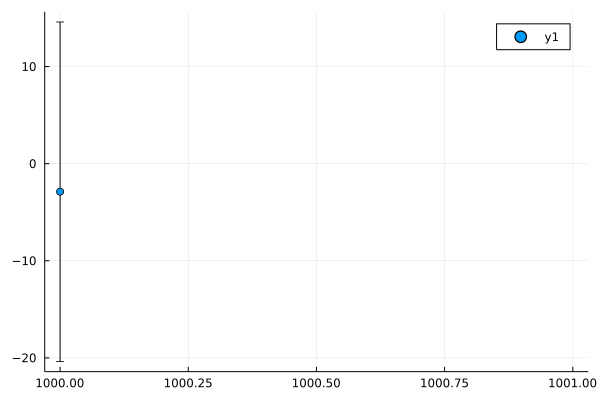

In [78]:
gap = obj_ub - objs[:, end]
μ = mean(gap);
σ = std(gap);
scatter([1000], [μ], yerror = 1.96*σ/sqrt(M))